## <font color=darkblue> Introduction to decision trees and random forests</font>


In this notebook, we provide an **overview of decision trees and random forests** and some insights on how to tune these models

### <font color=darkred> Bibliography & additional ressources </font>

-  [1] A Random Forest Guided Tour https://arxiv.org/abs/1511.05741, Biau G. and Scornet, E., 2015
``Review of the most recent theoretical and methodological developments for random forests``
- [2] SIRUS: Stable and Interpretable RUle Set for Classification, Bénard, C. et al., 2020 https://arxiv.org/abs/1908.06852


## <font color=darkred> Part I: Introduction and motivation</font>

Decision Trees and random forests are a non-parametric approaches used to solve supervised learning tasks (classification and regression). They aim at predicting the pobability that a data belongs to a class (classification), or the value of the observations (regression) with few simple decision rules inferred from the data features.

A common feature of all decision trees-based methods is that they are piecewise constant estimators.

Some details pros and cons of decision trees can be found here for instance https://scikit-learn.org/stable/modules/tree.html

Decision trees are popular for many reasons. In particular, they do not require a lot of  data preparation during pre-processing.

- Decision tree **do not require normalization or scaling of data**.
- Missing values in the data also do not affect the process the training process.
- Decision trees provide a few decision rules which makes them **interpretable AI solutions**.

In a classification setting for instance, they require very few tuning of hyperparameters to **produce nonlinear, complex classification decisions**.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png)

Example from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html#sphx-glr-auto-examples-ensemble-plot-forest-iris-py

DecisionTree with features [0, 1] has a score of 0.9266666666666666
RandomForest with 30 estimators with features [0, 1] has a score of 0.9266666666666666
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.9266666666666666
AdaBoost with 30 estimators with features [0, 1] has a score of 0.8666666666666667
DecisionTree with features [0, 2] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.9933333333333333
DecisionTree with features [2, 3] has a score of 0.9933333333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.9933333333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.9933333333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.9933333333333333


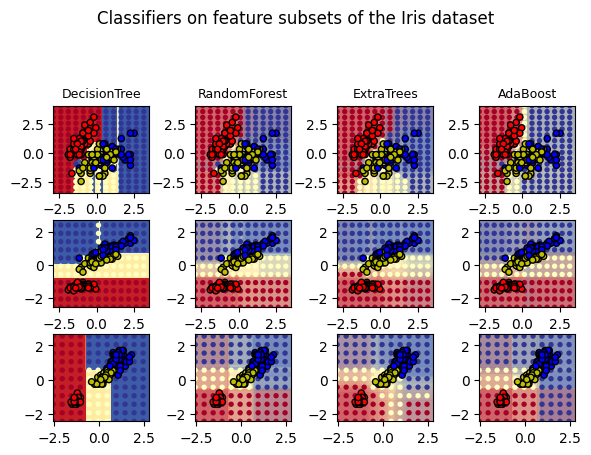

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [
    DecisionTreeClassifier(max_depth=None),
    RandomForestClassifier(n_estimators=n_estimators),
    ExtraTreesClassifier(n_estimators=n_estimators),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=n_estimators),
]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target

        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        model.fit(X, y)

        scores = model.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][: -len("Classifier")]

        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print(model_details + " with features", pair, "has a score of", scores)

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title, fontsize=9)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number
            # of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a
        # black outline
        xx_coarser, yy_coarser = np.meshgrid(
            np.arange(x_min, x_max, plot_step_coarser),
            np.arange(y_min, y_max, plot_step_coarser),
        )
        Z_points_coarser = model.predict(
            np.c_[xx_coarser.ravel(), yy_coarser.ravel()]
        ).reshape(xx_coarser.shape)
        cs_points = plt.scatter(
            xx_coarser,
            yy_coarser,
            s=15,
            c=Z_points_coarser,
            cmap=cmap,
            edgecolors="none",
        )

        # Plot the training points, these are clustered together and have a
        # black outline
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=y,
            cmap=ListedColormap(["r", "y", "b"]),
            edgecolor="k",
            s=20,
        )
        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset", fontsize=12)
plt.axis("tight")
plt.tight_layout(h_pad=0.2, w_pad=0.2, pad=2.5)
plt.show()

## <font color=darkred> Part II: Decision trees </font>

Assume that the input data $x\in [0,1]^d$ and that the observation $y\in\mathbb{R}$. Trees **decompose the input space into non overlapping cells** and are built **recursively by splitting each cell into two children** until some stopping criterion is satisfied. A cell is a region of the input data ($x$) space, a node in the tree is a cell.

![](https://images.datacamp.com/image/upload/v1677504957/decision_tree_for_heart_attack_prevention_2140bd762d.png)

**Breiman Tree for regression**

 For a split direction $j\in \{1, \ldots , d\}$, a cell $A$, and a split position $z \in [0, 1]$, the
CART criterion takes the form
$$
L_n(j, z,A) = \frac{1}{N_n(A)}\sum_{i=1}^n\left(Y_i - \bar Y_{A_L}\mathbb{1}_{x_i(j)<z}- \bar Y_{A_R}\mathbb{1}_{x_i(j)>z}\right)^2
$$
where
$$
A_L = \{x_i\;;\; x_i(j)<z\} \quad A_R = \{x_i\;;\; x_i(j)>z\}
$$
and
$\bar Y_{A_L}$ is the average of the observations associated with the $x_i$ in $A_L$ and $N_n(A)$ is the number of $x_i$ i n$A$.

**Breiman Tree for classification**

Let the data at node  be represented by $A$ with $n_m$ samples. For each candidate split $\theta = (z,j)$  consisting of a feature  $j$ and threshold $z$ , partition the data into $A_L$ and $ A_R$ subsets.

$$
A_L = \{x_i\;;\; x_i(j)<z\}\,.
$$

The quality of a candidate split of node  is then computed using an impurity function or loss function $H$,
$$
L_n(j, z,A) = \frac{n_m^R}{n_m}H(A_R) + \frac{n_m^L}{n_m}H(A_L)\,.
$$
Select the parameters that minimises the impurity:
$$
(j_*,z_*) \in \mathrm{argmin}_{j,z} L_n(j, z,A)\,.
$$

If a target is a classification outcome taking values in $\{1,\ldots,K\}$ write
$$
p_k = \frac{1}{n_m}\sum_{x_i\in A}\mathbb{1}_{y_i = k}\,.
$$
The two most common criteria fro classification are:

**Gini**

$$
H(A) = \sum_{k=1}^{K}p_k(1-p_k)\,.
$$

**Entropy**

$$
H(A) = - \sum_{k=1}^K p_k \log p_k\,.
$$



**Elementary Breiman tree splitting**

Select $a_n$ ``observations with replacement`` among the original sample $D_n$. Use only these observations to build the tree.

For each cell $A$ (starting with $[0,1]^d$),

• Select randomly ``mtry`` coordinates among $\{1, \ldots , d\}$;

• Choose the best split along previous direction, the one minimizing
the CART criterion.

$$
(j_*,z_*) \in \mathrm{argmin}_{j,z} L_n(j, z,A)
$$

• Replace $A$ by $A_L$ and $A_R$.

• Stop when each cell contains less than ``nodesize`` observations.


Theoretical works first **focused on convergence and upper bounds
on the quadratic risk** of a forest:

• ``stylized forests``, whose construction is independent of the dataset
[Biau et al., 2008, Biau, 2012, Genuer, 2012, Zhu et al., 2015, Arlot and
Genuer, 2014, Scornet, 2016b, Klusowski, 2018, Mourtada et al., 2020]

• ``forest algorithms`` close to the original algorithm
[Scornet et al., 2015, Scornet, 2016a, Wager and Walther, 2015]

### CART for classification - toy example from sklearn

Example from https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

In [ ]:
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X, y = make_hastie_10_2(n_samples=8000, random_state=42)

# The scorers can be either one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={"min_samples_split": range(2, 403, 20)},
    scoring=scoring,
    refit="AUC",
    n_jobs=2,
    return_train_score=True,
)
gs.fit(X, y)
results = gs.cv_results_

The Receiver Operating Characteristic (ROC) curve assesses the diagnostic ability of the classifier  as the classification threshold is modified. The **Bayes classifier** is defined as

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > \mathbb{P}(Y = 0| X)$,

which is equivalent to

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) >1/2$.

Therefore, the **theoretical threshold to classify individuals is $1/2$**. However, analyzing the sensitivity of the classifier to this threshold may be interesting which is the aim of the ROC curve which displays the **True positive rate as a function of the False positive rate when the threshold is changed**. For each value $p^*\in(0,1)$ the ROC curve classifies individuals using

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > p^*$

and plots the True positive rate as a function of the False positive rate.

Depending on the application, an optimal threshold may then be used to obtain satisfying True and False positive rates on the test data set.

The **AUC is the area under this curve**.

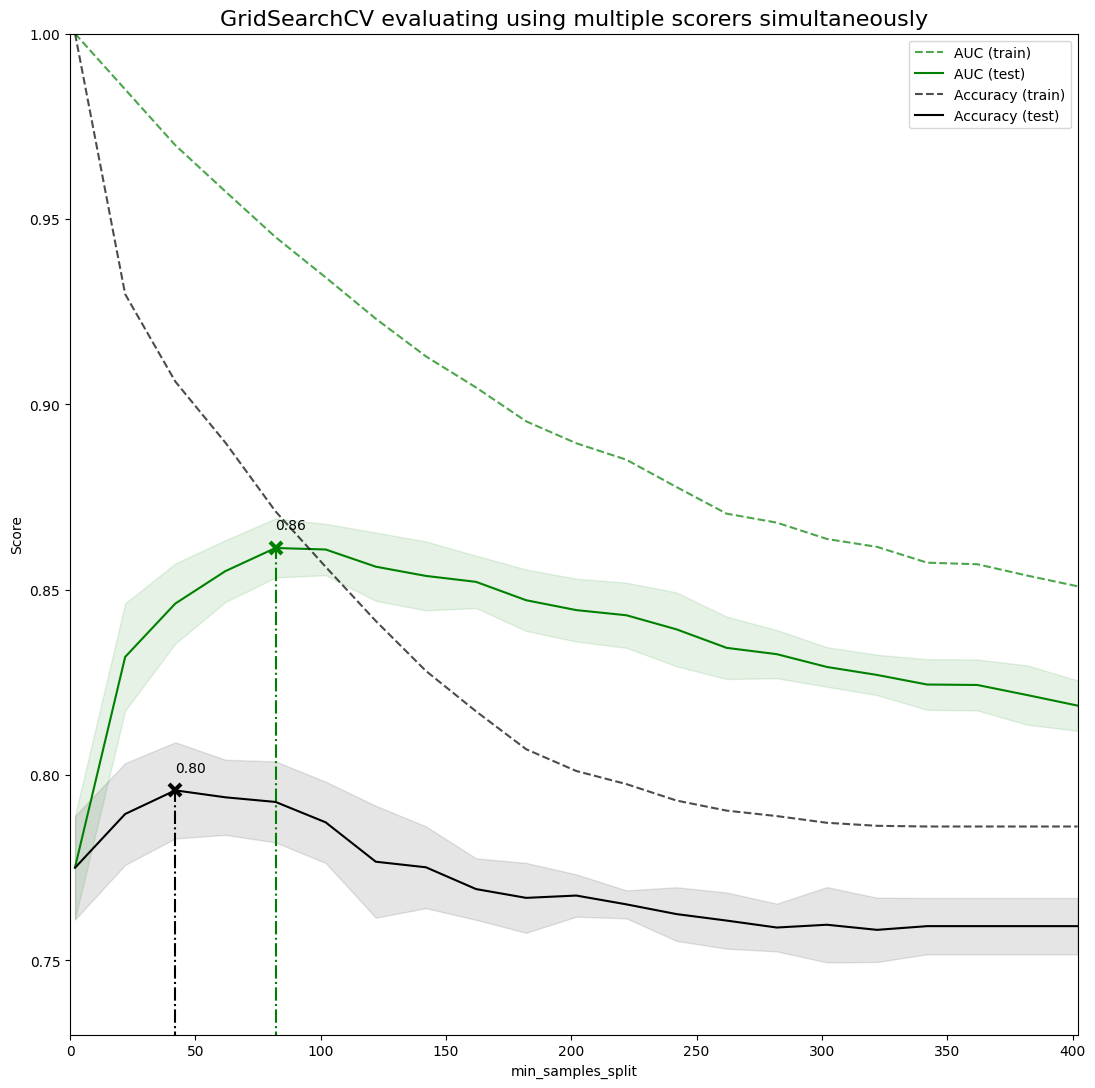

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_split"].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

## <font color=darkred> Part III: Random forests and extensions</font>

Random forests are ensemble learning-based methods to solve classification or regression tasks. They use a multitude of decision trees at training time.

Random forests build a **large collection of de-correlated trees** to further improve predictive performance. They have become a go-to solution as an “out-of-the-box” or “off-the-shelf” learning algorithm with striking predictive performance with relatively little hyperparameter tuning.

For classification tasks, the output of the random forest is the mean of the probability vectors outputed by each tree.

For regression tasks, the mean prediction of all trees is returned.

Illustration from (Machado et al., 2015)

![](https://www.researchgate.net/profile/Hu-Ding/publication/317274960/figure/fig3/AS:573294589026305@1513695489820/llustration-of-random-forest-a-In-the-training-process-each-decision-tree-is-built.png)


Illustration of random forest. (a) In the training process, each decision tree is built based on a bootstrap sample of the training set, which contains two kinds of examples (green labels and red labels). (b) In the classification process, decision for the input instance is based on the majority voting results among all individual trees. (Machado et al., 2015)

In a general framework of nonparametric regression estimation, with input random vector $X$, the goal
is to predict the observations $Y$ by estimating the
regression function $m(x) = \mathbb{E}[Y |X ]$. Consider a training sample $D_n = \{(X_1, Y_1), \ldots ,(X_n, Y_n)\}$ of independent
random variables.

The goal is to use the data set to construct an estimate $m_n$ of $m$.

A random forest is a predictor consisting of a collection of $M$ randomized regression trees. For the $j$-th tree in the family, the predicted value at the query point x is denoted by $m_n(x; \theta_j
, D_n)$, where $\theta_1, \ldots , \theta_M$ are independent random variables. The $j$-th tree estimate takes the form

$$
m_n(x; \theta_j
, D_n) = \sum_{i} \frac{\mathbb{1}_{X_i∈A_n(x;\theta_j ,D_n)}Y_i}{N_n(x; \theta_j
, D_n)}\,,
$$
where $A_n(x; \theta_j
, D_n)$ is the cell containing $x$, and $N_n(x; \theta_j
, D_n)$ is the number of
(preselected) points that fall into $A_n(x; \theta_j
, D_n)$.

**Trees are combined** to form the (finite) forest
estimate:
$$
m_{M,n}(x; \theta_1, \ldots , \theta_M, D_n) = \frac{1}{M}\sum_{j=1}^{M}m_n(x; \theta_j, D_n)\,.
$$

For each tree, $\theta_j$ contains all random choices to build the tree.

- The number of sampled data points to build each tree.
- The number of possible directions for splitting at
each node of each tree.
- The number of points in each cell below
which the cell is not split, etc.

**Variable importance**

Random forests can be used to rank the importance of variables in regression or classification problems via two measures of significance. The first, called
Mean Decrease Impurity, is based on the total decrease in node impurity from splitting on the variable, averaged over all trees.
The second, referred to as Mean Decrease Accuracy (MDA), stems from the idea that if the variable is not important,
then rearranging its values should not degrade prediction accuracy.

Let $X = (X_1, \ldots , X_d)$. For a forest resulting from the aggregation of $M$ trees, the MDI of the variable $X_j$
is defined by:
$$
I_1(X_j) = \frac{1}{M}\sum_{\ell=1}^M\sum_{t\in T_\ell,j^*_{n = j}}p_{n,t} L(j^*_{n,t},z^*_{n,t})\,,
$$
where $p_{n,t}$ is the fraction of observation in the node $t$ of the tree $t$ and $j^*_{n,t},z^*_{n,t}$ the split that maximizes the
empirical criterion in node $t$.

Thus, the MDI of $X_j$ computes the weighted decrease of
impurity corresponding to splits along the variable $X_j$ and averages this quantity over all trees.

Example from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=3,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    random_state=0,
    shuffle=False,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [5]:
import time

import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.009 seconds


<Axes: >

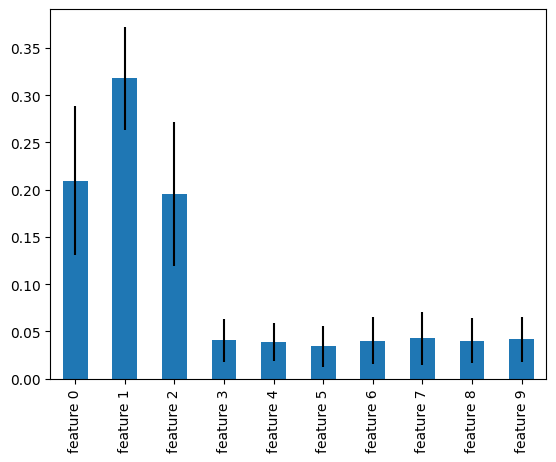

In [8]:
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

forest_importances.plot.bar(yerr=std)


### <font color=darkorange> Toy example for time series</font>

Consider a Markov chain, given by $X_0 = x_0$ for $x_0\in \mathbb{R}^d$ and, for $k\geqslant 0$,

$$
X_{k+1} = \rho X_k + \sigma_X\varepsilon_k\,\,\, [2\pi]\,
$$

where $(\epsilon_k)_{k\geqslant 0}$ are i.i.d. standard Gaussian vectors in $\mathbb{R}^d$ $\sim {\sf N}(0,{\bf I}_d)$.

The observation model is

$$
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$

where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$ and

$$
f:\begin{cases}
\mathbb{R}^d\to\mathbb{R}\\
{\bf x} \mapsto \sum_{i=1}^{d}\cos(x_i)
\end{cases}\,.
$$

The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

Start with a few imports, in particular the function ``RandomForestRegressor`` of sklearn that enables to apply the random forest algorithm in python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

We can define a function that takes as input the size $d$ of the vector $x_0$, the size $n$ of the dataset, the noise levels $\sigma_X$ of the autoregressive model and $\sigma_Y$ of the observed values and the parameter $\rho$ in the autoregressive model.

The function outputs data following the model described above.

In [2]:
# function to sample a dataset
def sample_data_ar(rho,sigmax,sigmay,n,d):
    X       = np.zeros(shape=(n,d))
    Y       = np.zeros(n)
    epsilon = np.random.normal(loc=0,scale=1,size = X.shape)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = np.sum(np.cos(X[0,:])) + sigmax*eta[0]
    for k in range(1,n):
        X[k,:] = (rho*X[k-1,:] + sigmax*epsilon[k,:])%(2*np.pi)
        Y[k]   = np.sum(np.cos(X[k,:])) + sigmay*eta[k]
    return X, Y

In [10]:
# set parameters
n_train = 2000
n_test = 200
d = 10

rho    = 0.8
sigmax = 0.2
sigmay = 0.01

In [11]:
# sample data
X_train, Y_train = sample_data_ar(rho,sigmax,sigmay,n_train,d)
X_test, Y_test = sample_data_ar(rho,sigmax,sigmay,n_test,d)

A first random forest prediction can be performed.
``rf`` is the random forest function of sklearn when the number of trees in the forest is set to ``n\_trees``.
The forest is estimated using the training data ``X\_train`` and ``Y\_train`` and the values of $Y$ in the test set are compared to those predicted by the algorithm.
The mean-squared error between these quantities is also displayed.

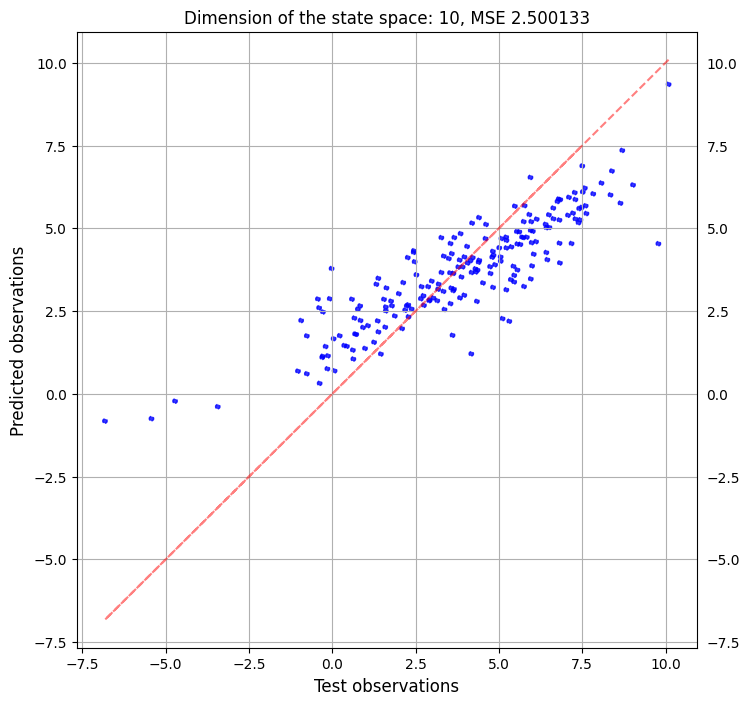

In [12]:
# number of trees in the forest for an elementary random forest estimate
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

The predictions seem reasonable but it may be that these predictions are very accurate at first and then that the errors accumulate over time.
To test if this is the case, plot the values of $Y$ in the test set (true and predicted) as functions of the time from the last training time.

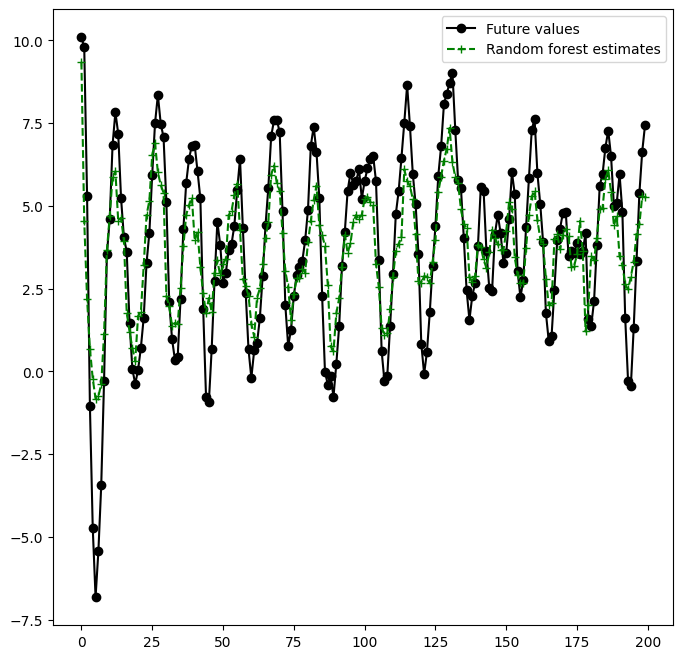

In [13]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

Many variables are used for the inflation prediction while very few observations are available.
Selecting the most valuable variables is an alternative which may be achieved using ``rf.feature_importances_``

In [14]:
rf.feature_importances_

array([0.14794905, 0.06934019, 0.10575746, 0.11041438, 0.12332589,
       0.08970279, 0.06440213, 0.10399496, 0.07373885, 0.11137432])

``RandomForestClassifier`` and ``RandomForestRegressor`` use the gini importance mechanism as a measure of the fetaures importance. The mean decrease in impurity importance of a feature is computed, see https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf

### <font color=darkorange> Hyperparameter tuning</font>

To improve this first prediction, the different parameters of the random forest algorithm may be tuned. For example, an increase of the number of trees in the forest reduced the variance of the Monte Carlo estimate.

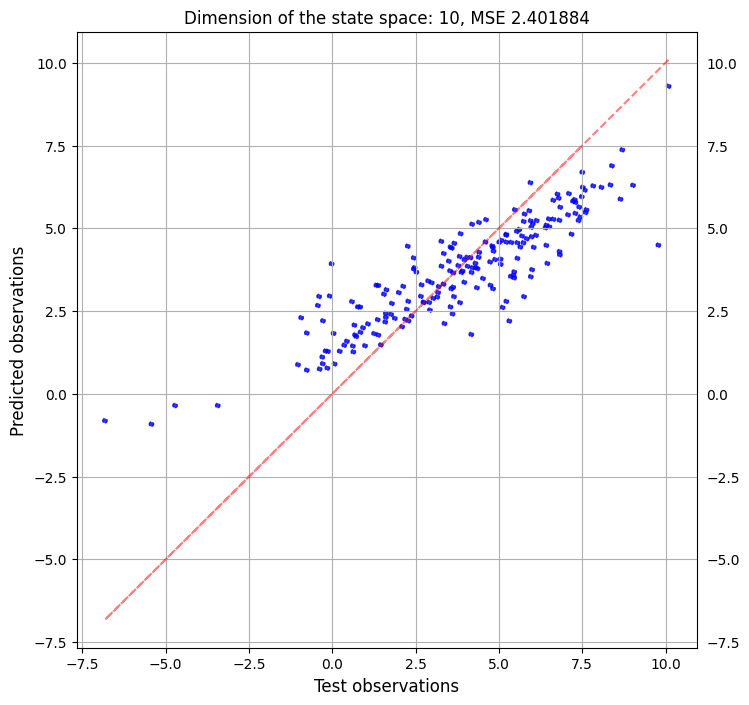

In [15]:
# number of trees in the forest
n_trees = 500
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)


plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

The objective is now to improve the algorithm using a cross-validation scheme to estimate the best value of these parameters. It is useful to look at the parameters used by default in the algorithm here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Set a grid of parameters that will be tested by the cross-validation procedure.

In [ ]:
# with RandomizedSearchCVCreate, a grid of tuning parameters is built
# then a random search will be performed to test which parameter values yield the best
# random forest estimate (see below).
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree.
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Exploring all parameters combinations in this grid would be computationally prohibitive.
An efficient alternative is to compare parameters chosen at random in the grid.

In [ ]:
rf = RandomForestRegressor()
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!).
# search across n_iter = 10 different combinations with a default 3-fold cross validation.
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=10, n_jobs = -1)

rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   verbose=10)

In [ ]:
# display the best parameters
rf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 95,
 'bootstrap': False}

In [ ]:
# build the best explored random forest
best_random = rf_random.best_estimator_
y_pred_rf = best_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

In [ ]:
plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf,linestyle = "dashed", color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='red', linestyle = 'dashed', alpha = 0.5)
plt.xlabel('Test observations', fontsize=12)
plt.ylabel('Predicted observations', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')

In [ ]:
# compute predictions usting test data and associated mean square error
y_pred_rf = rf_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

### <font color=darkorange> Interpretable forests with SIRUS</font>

SIRUS is a regression and classification algorithm based on random forests, which takes the form of a stable and short list of rules.

See https://gitlab.com/drti/sirus

As in the original procedure, each single tree in the forest
is grown by recursively partitionning the input space.

The essential difference  is that, **prior to all tree constructions, the empirical q-quantiles of the marginal distributions over the whole
dataset are computed**. In each node of each tree, the best split **can be selected among these empirical quantiles only**.

This constraint is critical to stabilize the forest structure and keeps almost intact the predictive accuracy, provided q is not too small.

Let $\hat q_{n,j}^r$ the $r$-th quantile of $\{X_1(j),\ldots,X_n(j)\}$.

**Tree construction**

- Compute the empirical q-quantiles for each marginal distribution over the whole dataset.

- Subsample with replacement $a_n$ observations. Only these observations are used to build the tree.

- Initialize the cell $H$ as the root of the tree.

- Draw uniformly at random a subset in  $\Theta\subset\{1, \ldots , p\}$ of cardinality ``mtry``.

- For all $j \in\Theta$, compute the CART-splitting criterion at all empirical q-quantiles of $X_j$. that split the cell H into two non-empty cells.

- Choose the split that maximizes the CART-splitting criterion.

- Recursively repeat the process to the two resulting children cells $H_L$ and $H_R$.

![](https://d3i71xaburhd42.cloudfront.net/17256c6758eb813ec85f803d791e43dfef7af1db/6-Figure1-1.png)

**Decision rule**

A path
describes the sequence of splits to go from the root of the tree to a specific  node. A rule can be defined as a piecewise
constant estimate with this hyperrectangle as support. By construction, there is **some redundancy in the list of rules generated by the set of distinct paths**.

We are interested in **selecting the most important
rules**, i.e., those **which represent strong patterns** between the inputs and the output, we select
rules that are shared by a large portion of trees. Such occurrence frequency is formally written $\hat p_{n,M}(R)$ for a rule $R$.

Then, we can fix a threshold $p_0$ and only keep the rules $R$ such that $\hat p_{n,M}(R)>p_0$.

![](https://d3i71xaburhd42.cloudfront.net/17256c6758eb813ec85f803d791e43dfef7af1db/20-Figure5-1.png)

Predictivity versus the number of rules when $p_0$ varies, with the optimal $p_0$ displayed. Notice that the relation between $p_0$ and the number of rules is monotone by
construction, but also highly nonlinear.